# **Cosinor Regression Model**

In [5]:
import numpy as np
from statsmodels.api import OLS
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def design_matrix(t_hours, harmonics, period=24.0):
    """
    Build a design matrix with columns:
      [1, sin(2πnt / period), cos(2πnt / period) for each n in harmonics]
    """
    X_cols = [ np.ones_like(t_hours) ]
    for n in harmonics:
        ω = 2 * np.pi * n / period
        X_cols.append(np.sin(ω * t_hours))
        X_cols.append(np.cos(ω * t_hours))
    return np.column_stack(X_cols)

def fit_cosinor_with_cv(t_window, y_window, candidate_harmonics):
    """
    t_window: 1D array of timepoints (in hours) for a 5-day chunk (length 720).
    y_window: 1D array of normalized LFP values (length 720).
    candidate_harmonics: list of integers, e.g. [1, 2] for 24h & 12h components.
    """
    # 1. Set up 5-fold CV on 720 samples
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    # Count how many folds each harmonic is significant in
    sig_counts = {n: 0 for n in candidate_harmonics}

    for train_idx, test_idx in kf.split(t_window):
        # Training data
        t_tr = t_window[train_idx]
        y_tr = y_window[train_idx]
        X_tr = design_matrix(t_tr, harmonics=candidate_harmonics)

        # Fit full-model OLS on training set
        model_tr = OLS(y_tr, X_tr).fit()
        pvals = model_tr.pvalues[1:]  # skip intercept; then pairs (sin, cos) per harmonic

        # Check significance per harmonic
        for i, n in enumerate(candidate_harmonics):
            p_sin = pvals[2*i]
            p_cos = pvals[2*i + 1]
            if (p_sin < 0.05) or (p_cos < 0.05):
                sig_counts[n] += 1

    # 2. Retain harmonics significant in >= 3 folds
    retained = [n for n in candidate_harmonics if sig_counts[n] >= 3]

    # 3. Final fit on all 720 points with only retained harmonics
    X_full = design_matrix(t_window, harmonics=retained)
    final_model = OLS(y_window, X_full).fit()

    # 4. Extract amplitudes & acrophases for each retained harmonic
    amplitudes = []
    acrophases  = []  # in hours after midnight
    for i, n in enumerate(retained):
        A_sin = final_model.params[1 + 2*i]
        A_cos = final_model.params[1 + 2*i + 1]
        R     = np.sqrt(A_sin**2 + A_cos**2)
        # Acrophase φ satisfies:  A_sin*sin(2π t/24) + A_cos*cos(2π t/24) = R*cos(2π t/24 - φ)
        φ_rad = np.arctan2(-A_cos, A_sin)  # φ in radians
        φ_hr  = (φ_rad / (2*np.pi) * 24.0) % 24.0
        amplitudes.append(R)
        acrophases.append(φ_hr)

    # 5. Primary amplitude & acrophase
    if len(amplitudes) > 0:
        idx_max = int(np.argmax(amplitudes))
        primary_amplitude = amplitudes[idx_max]
        primary_acrophase = acrophases[idx_max]
    else:
        primary_amplitude = 0.0
        primary_acrophase = np.nan

    # 6. Compute cross-validated R2 (average over 5 folds)
    r2_list = []
    for train_idx, test_idx in kf.split(t_window):
        t_tr, t_te = t_window[train_idx], t_window[test_idx]
        y_tr, y_te = y_window[train_idx], y_window[test_idx]
        X_tr = design_matrix(t_tr, harmonics=retained)
        X_te = design_matrix(t_te, harmonics=retained)

        model_cv = OLS(y_tr, X_tr).fit()
        y_pred  = model_cv.predict(X_te)
        r2_fold = r2_score(y_te, y_pred)
        r2_list.append(r2_fold)
    daily_r2 = np.mean(r2_list)

    return primary_amplitude, primary_acrophase, daily_r2

def plot_lfp_heatmap(lfp_matrix, stimulus_days=None, vmin=-1, vmax=7, cmap='jet'):
    """
    Plot a heatmap of z-scored LFP power with days on x-axis and time of day on y-axis.
    Parameters:
    - lfp_matrix: 2D np.ndarray (days x time bins)
    - stimulus_days: list of int, days when stimulus occurred
    - vmin, vmax: color scale limits
    - cmap: colormap
    """
    plt.figure(figsize=(14, 6))
    # Transpose so days are x, time of day is y
    ax = sns.heatmap(lfp_matrix.T, cmap=cmap, vmin=vmin, vmax=vmax, cbar_kws={'label': 'Z-scored LFP Power (9-12 Hz)'})
    plt.xlabel('Days')
    plt.ylabel('Time of Day (hour)')
    plt.title('LFP Power Heatmap (Days x Time of Day)')
    if stimulus_days is not None:
        for i, day in enumerate(stimulus_days):
            plt.axvline(day, color='magenta', linestyle='--', linewidth=2, label='Stimulus' if i == 0 else "")
        handles, labels = ax.get_legend_handles_labels()
        if 'Stimulus' not in labels:
            plt.legend(['Stimulus'], loc='upper right')
    plt.show()

def reshape_to_matrix(df):
    df['date'] = pd.to_datetime(df['Region start time']).dt.date
    df['hour'] = pd.to_datetime(df['Region start time']).dt.hour
    matrix = df.pivot(index='date', columns='hour', values='Pattern A Channel 2')
    # Interpolate missing values along the row (hours), then fill any remaining NaNs with the row mean
    matrix = matrix.interpolate(axis=1, limit_direction='both')
    matrix = matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
    return matrix.values  # shape: (n_days, 24)

def load_and_process_lfp_data(pre_path, post_path):
    # Load CSVs
    pre_df = pd.read_csv(pre_path)
    post_df = pd.read_csv(post_path)
    # Reshape to (days, 24)
    pre_matrix = reshape_to_matrix(pre_df)
    post_matrix = reshape_to_matrix(post_df)
    # Combine for visualization
    combined_matrix = np.vstack([pre_matrix, post_matrix])
    stimulus_day = pre_matrix.shape[0]
    # Plot heatmap with stimulus event
    plot_lfp_heatmap(combined_matrix, stimulus_days=[stimulus_day])
    return pre_matrix, post_matrix, combined_matrix, stimulus_day

def run_daily_cosinor_analysis(matrix):
    results = []
    n_days, n_hours = matrix.shape
    t_window = np.arange(n_hours)  # hours in a day
    cand_harmonics = [1, 2]  # 24h & 12h
    for i in range(n_days):
        y_window = (matrix[i] - np.mean(matrix[i])) / np.std(matrix[i])  # z-score per day
        amp, phase, r2 = fit_cosinor_with_cv(t_window, y_window, cand_harmonics)
        results.append({'day': i, 'amplitude': amp, 'acrophase': phase, 'R2': r2})
    return results

# Initialize daily metrics dictionary
daily_metrics = {}

# Example of looping over sliding windows:
all_dates = np.arange('2020-01-01', '2023-12-31', dtype='datetime64[D]')  # Example dates
for D in all_dates:
    # Extract t_window (0 to 5*24 hours in 10-min steps) and y_window for days [D-2 ... D+2]
    t_window = np.linspace(0, 5*24, 5*24*6)  # 720 points (in hours)
    cand_harmonics = [1, 2]  # e.g. 24h & 12h components

    # Store daily metrics:
    # daily_metrics[D] = {
    #     "amplitude": amp,
    #     "acrophase": phase,
    #     "R2": r2
    # }

# Example usage (uncomment to run):
# pre_matrix, post_matrix, combined_matrix, stimulus_day = load_and_process_lfp_data(
#     'CosinorRegressionModel(TRPTSD)/data/RNS_G_Pre_output.csv',
#     'CosinorRegressionModel(TRPTSD)/data/RNS_G_M1_output.csv')
# pre_results = run_daily_cosinor_analysis(pre_matrix)
# post_results = run_daily_cosinor_analysis(post_matrix)
# print('Pre-stimulus daily cosinor results:', pre_results)
# print('Post-stimulus daily cosinor results:', post_results)

def plot_metric_comparison(pre_results, post_results, metric, ylabel):
    """
    Plot line plot and boxplot for a given metric (amplitude, acrophase, R2).
    """
    import matplotlib.pyplot as plt
    pre_vals = [r[metric] for r in pre_results]
    post_vals = [r[metric] for r in post_results]
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))
    # Line plot
    axs[0].plot(pre_vals, label='Pre', color='blue')
    axs[0].plot(range(len(pre_vals), len(pre_vals)+len(post_vals)), post_vals, label='Post', color='orange')
    axs[0].axvline(len(pre_vals), color='magenta', linestyle='--', label='Stimulus')
    axs[0].set_xlabel('Day')
    axs[0].set_ylabel(ylabel)
    axs[0].set_title(f'Daily {ylabel}')
    axs[0].legend()
    # Boxplot
    axs[1].boxplot([pre_vals, post_vals], labels=['Pre', 'Post'])
    axs[1].set_ylabel(ylabel)
    axs[1].set_title(f'{ylabel} Distribution')
    plt.tight_layout()
    plt.show()

def print_metric_summary(pre_results, post_results, metric, label):
    import numpy as np
    pre_vals = np.array([r[metric] for r in pre_results])
    post_vals = np.array([r[metric] for r in post_results])
    print(f"{label} Summary:")
    print(f"  Pre:  mean={np.nanmean(pre_vals):.3f}, std={np.nanstd(pre_vals):.3f}, min={np.nanmin(pre_vals):.3f}, max={np.nanmax(pre_vals):.3f}")
    print(f"  Post: mean={np.nanmean(post_vals):.3f}, std={np.nanstd(post_vals):.3f}, min={np.nanmin(post_vals):.3f}, max={np.nanmax(post_vals):.3f}")

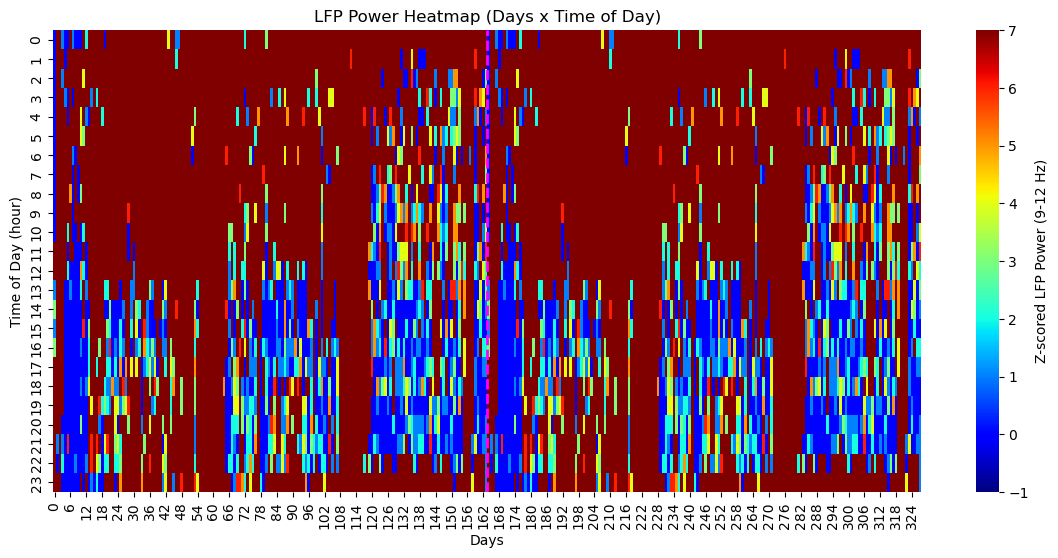

Pre-stimulus daily cosinor results: [{'day': 0, 'amplitude': 0.8082080341701026, 'acrophase': 13.120842543695055, 'R2': -2.008786426524181}, {'day': 1, 'amplitude': 0.7254397144955957, 'acrophase': 7.596538307022576, 'R2': -0.15788640223016712}, {'day': 2, 'amplitude': 1.0947027304525754, 'acrophase': 10.370746495585722, 'R2': 0.1560829753606429}, {'day': 3, 'amplitude': 0.8605711229460845, 'acrophase': 2.2755521790772666, 'R2': -10.470608395180552}, {'day': 4, 'amplitude': 0.9403684899095763, 'acrophase': 23.934837318631665, 'R2': -0.25065741147309645}, {'day': 5, 'amplitude': 0.802128027889576, 'acrophase': 22.62119382954575, 'R2': -416.1560476239758}, {'day': 6, 'amplitude': 0.8273997013484424, 'acrophase': 21.922375394606398, 'R2': -0.10533421684022981}, {'day': 7, 'amplitude': 0.0, 'acrophase': nan, 'R2': -2.135075249978668e+31}, {'day': 8, 'amplitude': 0.9424886114450114, 'acrophase': 22.54327931682137, 'R2': -326.8282046402286}, {'day': 9, 'amplitude': 0.8347101350919719, 'acrop

In [6]:
pre_matrix, post_matrix, combined_matrix, stimulus_day = load_and_process_lfp_data(
    'data/RNS_G_Pre_output.csv',
    'data/RNS_G_M1_output.csv')
pre_results = run_daily_cosinor_analysis(pre_matrix)
post_results = run_daily_cosinor_analysis(post_matrix)
print('Pre-stimulus daily cosinor results:', pre_results)
print('Post-stimulus daily cosinor results:', post_results)

In [7]:
print_metric_summary(pre_results, post_results, 'amplitude', 'Amplitude')
print_metric_summary(pre_results, post_results, 'acrophase', 'Acrophase')
print_metric_summary(pre_results, post_results, 'R2', 'R²')

Amplitude Summary:
  Pre:  mean=0.747, std=0.381, min=0.000, max=1.303
  Post: mean=0.747, std=0.381, min=0.000, max=1.303
Acrophase Summary:
  Pre:  mean=16.315, std=8.326, min=0.006, max=23.935
  Post: mean=16.315, std=8.326, min=0.006, max=23.935
R² Summary:
  Pre:  mean=-130187515242601710600838971392.000, std=1662122927879268308300007997440.000, min=-21350752499786680186693870419968.000, max=0.854
  Post: mean=-130187515242601710600838971392.000, std=1662122927879268308300007997440.000, min=-21350752499786680186693870419968.000, max=0.854


/var/folders/63/vz89pqnn20vfwc48f8kk0z5r0000gn/T/ipykernel_97511/1873756632.py:194: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([pre_vals, post_vals], labels=['Pre', 'Post'])


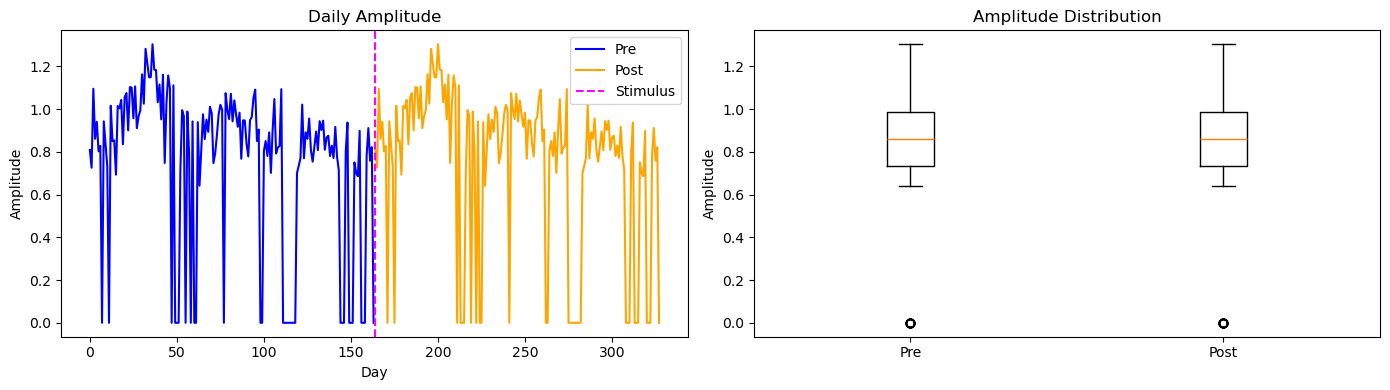

/var/folders/63/vz89pqnn20vfwc48f8kk0z5r0000gn/T/ipykernel_97511/1873756632.py:194: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([pre_vals, post_vals], labels=['Pre', 'Post'])


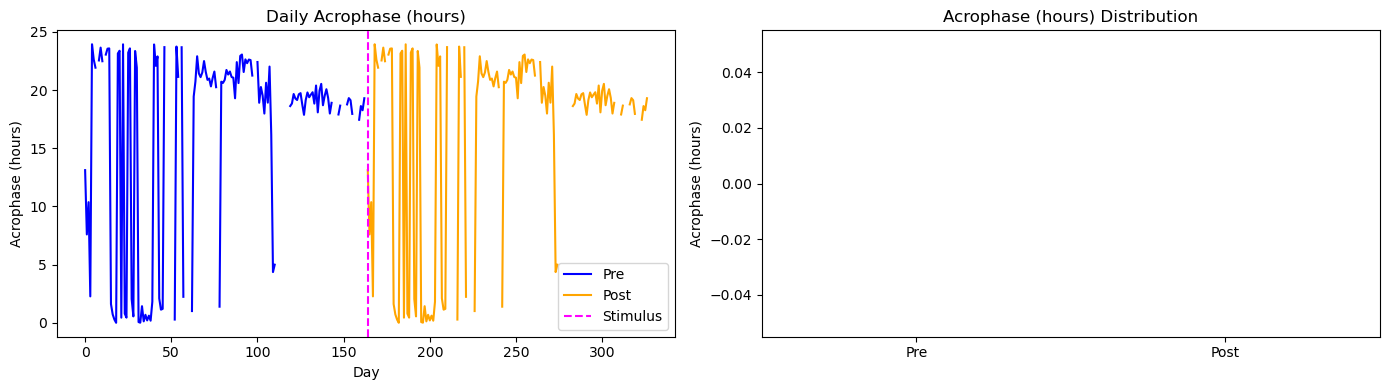

/var/folders/63/vz89pqnn20vfwc48f8kk0z5r0000gn/T/ipykernel_97511/1873756632.py:194: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot([pre_vals, post_vals], labels=['Pre', 'Post'])


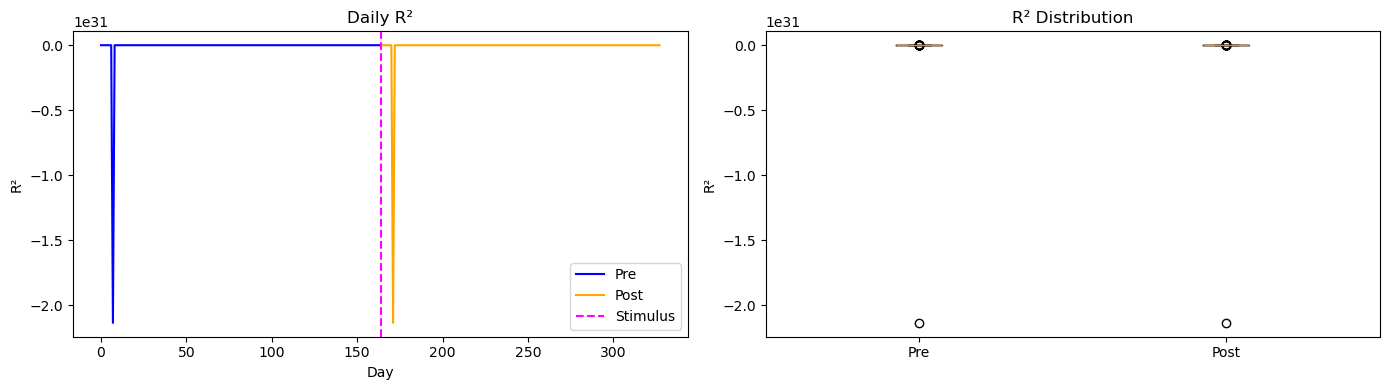

In [8]:
plot_metric_comparison(pre_results, post_results, 'amplitude', 'Amplitude')
plot_metric_comparison(pre_results, post_results, 'acrophase', 'Acrophase (hours)')
plot_metric_comparison(pre_results, post_results, 'R2', 'R²')